# Lab03 - Validación de Modelos

Configuración de librerías.

In [1]:
library(dplyr)
library(ggplot2)
library(caTools)
library(caret)
library(class)
library(e1071)
library(glmnet)
library(elasticnet)
library(yardstick)
library(data.table)
library(PRROC)
library(tidymodels)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: lars

Loaded lars 1.2


For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.


Attaching package: ‘yardstick’


The following objects are masked from ‘package:caret’:

    precision, recall, sensitivity, specificity



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.1      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.8 
✔ infer     0.5.3      ✔ tibble    3.0.3 
✔ modeldata 0.1.0      ✔ tidyr     1.1.2 
✔ par

## Cargar el set de datos

En este laboratorio vamos a validar qué tan bien se están comportando los modelos que realizamos la [clase pasada](https://gtzambranop.github.io/UN_2020_2/DCD/module_5/class_2/jupyter/lab02r_prediction_classification.html).  Por eso fue tan importante guardar los modelos ya entrenados, para no tener que entrenarlos nuevamente.
Vamos a continuar usando el set de datos que limpiamos y transformamos en el [primer laboratorio](https://gtzambranop.github.io/UN_2020_2/DCD/module_5/class_1/jupyter/lab01r_preprocessing.html) en donde se registran los atributos de varias botellas de vino junto con su calidad, ya que de este generamos los subsets de entrenamiento y prueba y es precisamente con el de **prueba** que vamos a probar y validar el modelo:

In [2]:
wine_df <- read.csv('data/winequality-white_clean.csv', header = T, fileEncoding = 'utf-8')
glimpse(wine_df)

Rows: 4,461
Columns: 12
$ fixed_acidity        <dbl> 7.0, 6.3, 8.1, 7.2, 7.2, 8.1, 6.2, 7.0, 6.3, 8.1…
$ volatile_acidity     <dbl> 0.27, 0.30, 0.28, 0.23, 0.23, 0.28, 0.32, 0.27, …
$ citric_acid          <dbl> 0.36, 0.34, 0.40, 0.32, 0.32, 0.40, 0.16, 0.36, …
$ residual_sugar       <dbl> 20.7, 1.6, 6.9, 8.5, 8.5, 6.9, 7.0, 20.7, 1.6, 1…
$ chlorides            <dbl> 0.045, 0.049, 0.050, 0.058, 0.058, 0.050, 0.045,…
$ free_sulfur_dioxide  <dbl> 45, 14, 30, 47, 47, 30, 30, 45, 14, 28, 17, 16, …
$ total_sulfur_dioxide <dbl> 170, 132, 97, 186, 186, 97, 136, 170, 132, 129, …
$ density              <dbl> 1.0010, 0.9940, 0.9951, 0.9956, 0.9956, 0.9951, …
$ pH                   <dbl> 3.00, 3.30, 3.26, 3.19, 3.19, 3.26, 3.18, 3.00, …
$ sulphates            <dbl> 0.45, 0.49, 0.44, 0.40, 0.40, 0.44, 0.47, 0.45, …
$ alcohol              <dbl> 8.8, 9.5, 10.1, 9.9, 9.9, 10.1, 9.6, 8.8, 9.5, 1…
$ score                <dbl> 6.15, 6.67, 6.48, 6.74, 6.45, 6.26, 6.70, 6.41, …


In [3]:
set.seed(42)
x = wine_df[, !names(wine_df) %in% c("score", "density")] %>% as.matrix()
y = wine_df['score'] %>% as.matrix()
sample = sample.split(wine_df[,1], SplitRatio = .75)
train_df = subset(wine_df, sample == TRUE)
test_df  = subset(wine_df, sample == FALSE)

x_train = train_df[, !names(train_df) %in% c("score","density")] %>% as.matrix()
x_test = test_df[, !names(test_df) %in% c("score", "density")] %>% as.matrix()
y_train = train_df['score']
y_test = test_df['score']

## 3a. Predicción

Si todo ha ido bien, en nuestro [laboratorio anterior](https://gtzambranop.github.io/UN_2020_2/DCD/module_5/class_2/jupyter/lab02r_prediction_classification.html), hemos guardado el modelo de regresión polinomial, que podemos validar en esta clase.  
Este modelo ya se encuentra entrenado y ahora, solo debemos cargarlo:

In [4]:
modelo <- readRDS("models/model_ols.rds")
modelo


Call:
lm(formula = score ~ fixed_acidity + volatile_acidity + citric_acid + 
    residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + 
    density + pH + sulphates + alcohol, data = wine_df)

Coefficients:
         (Intercept)         fixed_acidity      volatile_acidity  
           1.535e+02             1.088e-01            -1.673e+00  
         citric_acid        residual_sugar             chlorides  
           1.496e-01             8.126e-02            -5.376e-01  
 free_sulfur_dioxide  total_sulfur_dioxide               density  
           4.251e-03            -6.263e-04            -1.543e+02  
                  pH             sulphates               alcohol  
           8.969e-01             6.693e-01             2.012e-01  


### Curvas de Validación
Como ya vimos, una de las formas de ver gráficamente en qué momento un modelo entra en sobreajuste debido a su complejidad es la *curva de Entrenamiento*.  En el caso de R, el algoritmo vuelve a entrenar el modelo bajo diferentes tamaños del dataset, además, nos muestra no solo la curva para el dataset de entrenamiento y pruebas sino para un dataset hipotético "resample" mostrándonos cómo mejoraría el modelo en caso de que los datos estuvieran desbalanceados.

> Vamos a crear una función para poderla usar con varios modelos, sin necesidad de repetir código:

In [5]:
curva_entrenamiento <- function(modelo, df, y_col) {
  lcurve_data <- learning_curve_dat(dat = df, 
                                 outcome = y_col,
                                 test_prop = 1/3, 
                                 ## `train` arguments:
                                 method = modelo,
                                 metric = "Rsquared"
                                 )
  ggplot(lcurve_data, aes(x = Training_Size, y = Rsquared, color = Data)) + 
    geom_smooth(method = loess, span = .8) +
    theme_bw()
}

Training for 10% (n = 297)
Training for 20% (n = 595)
Training for 30% (n = 892)
Training for 40% (n = 1190)
Training for 50% (n = 1488)
Training for 60% (n = 1785)
Training for 70% (n = 2083)
Training for 80% (n = 2380)
Training for 90% (n = 2678)
Training for 100% (n = 2976)


`geom_smooth()` using formula 'y ~ x'



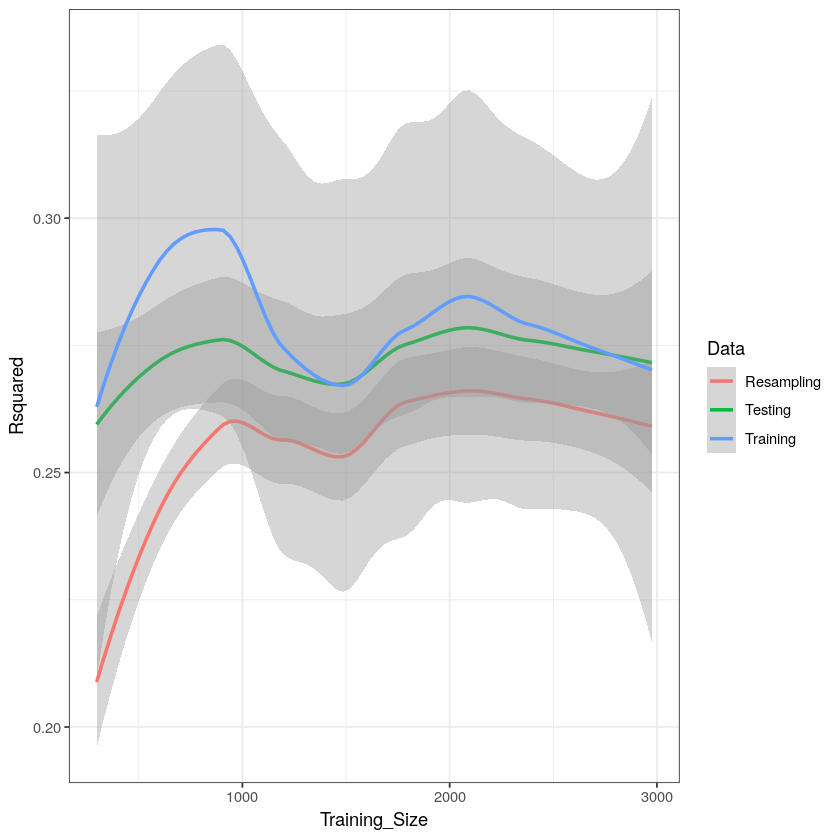

In [6]:
curva_entrenamiento("lm", wine_df, "score")

### Regularización
Aunque el modelo se ve bien a medida que el dataset crece, podríamos validar hasta qué punto el modelo se empieza a sobreajustar.  Esto es, reducir la complejidad del modelo (Cantidad o peso de las variables) obteniendo el mismo o mejor resultado.  Para esto existen dos metodos conocidos: *Lasso* y *Ridge*.  

> Tenga encuenta el factor de penalización del modelo recibe un nombre diferente en **Python** (*alpha*) y en **R** (*lambda*, que es como se conoce matemáticamente), pero el concepto, es el mismo. En R, adicionalmente existe tambien un concepto llamado *alpha* pero que tiene un significado diferente que veremos más adelante

**Lasso:**

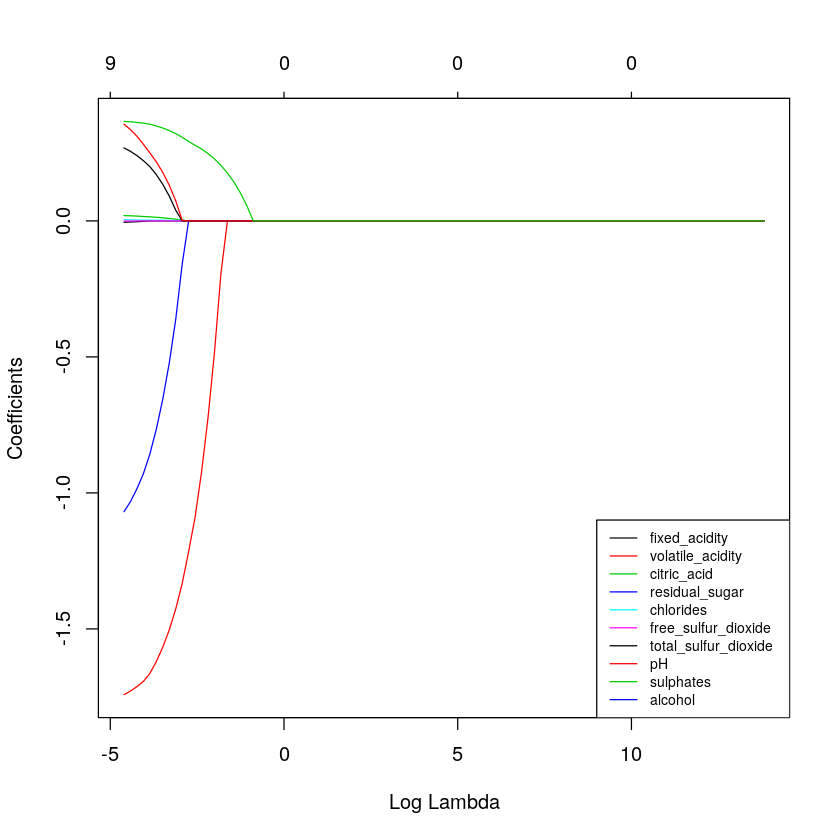

In [7]:
log_lambda_grid <- seq(-2, 6, length=100) # In reverse
lambdas_to_try <- 10^log_lambda_grid
model_lasso <- glmnet(x, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

plot(model_lasso, xvar = "lambda")
legend("bottomright", lwd = 1, col = 1:6, legend = colnames(x), cex = .7)

En la gráfica anterior se puede visualizar que si penalizamos mucho el peso de las variables (*lambda*), el modelo elimina todas las variables predictivas y esto no nos da ningún resultado.  Validemos ahora cuál es el mejor valor de lambda:

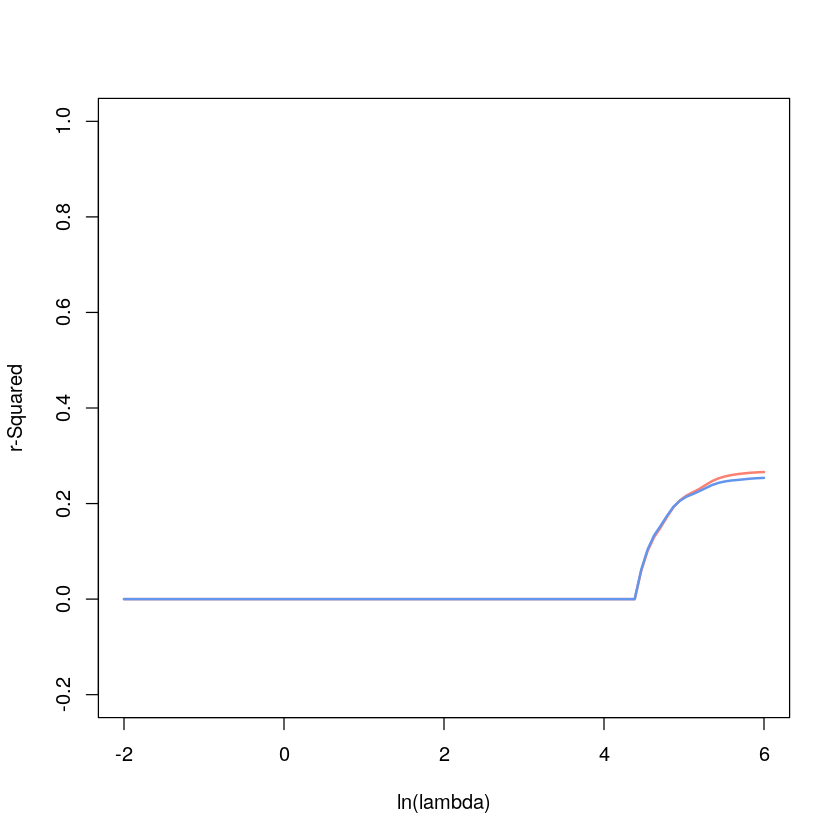

In [8]:
train_pred <- predict(model_lasso, x_train)
test_pred <- predict(model_lasso, x_test)

SSE_train <- colSums((train_pred - train_df$score)^2)
SSE_test <- colSums((test_pred - test_df$score)^2)

SST_train <- var(train_df$score) * (nrow(train_df) - 1)
SST_test <- var(test_df$score) * (nrow(test_df) - 1)

r2_train <- 1 - SSE_train / SST_train
r2_test <- 1 - SSE_test / SST_test

plot(x=log_lambda_grid, y=r2_train, ylim=c(-0.2,1), pch=".", col="salmon", 
     xlab="ln(lambda)", ylab="r-Squared")
lines(x=log_lambda_grid, y=r2_train, col="salmon", lwd=2)

lines(log_lambda_grid, r2_test, col="cornflowerblue", lwd=2)
legend(75, 1, legend=c("Training Acc", "Validation Acc"),
       col=c("salmon", "cornflowerblue"), lty=1, lwd=2, cex=0.8)

Revisemos, finalmente, el scor

## 2b. Clasificacióne de nuestro modelo bajo el mejor *lambda*.  Mejoro?

**Taller**  

- Pruebe con varios valores de *lambda* para mejorar el error mínimo cuadrado del modelo y la curva de entrenamiento
- Pruebe ahora cambiando el parámetro *alpha* por **0** y haga el mismo ejercicio.  Esto permite ejecutar un modelo bajo Regularización *Ridge*.
- Si queda algo de tiempo, intente eliminar columnas que, según nuestro analisis de los últimos días generan ruido en el modelo
- Finalmente, cuál es el mejor modelo que encontró?

## 2b. Clasificación

In [9]:
wine_df <- read.csv('data/winequality-red_clean.csv', header = T, fileEncoding = 'utf-8')
glimpse(wine_df)

Rows: 1,571
Columns: 12
$ fixed_acidity        <dbl> 7.4, 7.8, 7.8, 11.2, 7.4, 7.4, 7.9, 7.3, 7.8, 7.…
$ volatile_acidity     <dbl> 0.700, 0.880, 0.760, 0.280, 0.700, 0.660, 0.600,…
$ citric_acid          <dbl> 0.00, 0.00, 0.04, 0.56, 0.00, 0.00, 0.06, 0.00, …
$ residual_sugar       <dbl> 1.9, 2.6, 2.3, 1.9, 1.9, 1.8, 1.6, 1.2, 2.0, 6.1…
$ chlorides            <dbl> 0.076, 0.098, 0.092, 0.075, 0.076, 0.075, 0.069,…
$ free_sulfur_dioxide  <dbl> 11, 25, 15, 17, 11, 13, 15, 15, 9, 17, 15, 17, 1…
$ total_sulfur_dioxide <dbl> 34, 67, 54, 60, 34, 40, 59, 21, 18, 102, 65, 102…
$ density              <dbl> 0.9978, 0.9968, 0.9970, 0.9980, 0.9978, 0.9978, …
$ pH                   <dbl> 3.51, 3.20, 3.26, 3.16, 3.51, 3.51, 3.30, 3.39, …
$ sulphates            <dbl> 0.56, 0.68, 0.65, 0.58, 0.56, 0.56, 0.46, 0.47, …
$ alcohol              <dbl> 9.4, 9.8, 9.8, 9.8, 9.4, 9.4, 9.4, 10.0, 9.5, 10…
$ high_quality         <int> 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, …


In [10]:
x = wine_df[, !names(wine_df) %in% c("high_quality")] %>% as.matrix()
y = factor(wine_df['high_quality'])
sample = sample.split(wine_df[,1], SplitRatio = .75)
train_df = subset(wine_df, sample == TRUE)
test_df  = subset(wine_df, sample == FALSE)
x_test = test_df[, !names(test_df) %in% c("high_quality")]
y_test = test_df$high_quality

En nuestro [laboratorio anterior](./Lab02r_PrediccionClasificacion.Rmd), también hemos entrenado y guardado varios modelos de clasificación, que podemos validar en esta clase para encontrar el mejor:
- Regresión Logística (model_log.rds)
- Vecinos más Cercanos (model_knn.rds)
- Máquina de Soporte Vectorial (model_svm.rds)
- Arbol de Desición (model_tree.rds)
- Bosque Aleatorio (model_forest.rds)

Elijamos inicialmente uno para hacer este laboratorio:

In [11]:
modelo <- readRDS("models/model_svm.rds")
modelo


Call:
svm.default(x = x_train, y = y_train, kernel = "radial")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.09090909 
    epsilon:  0.1 


Number of Support Vectors:  913


### Matriz de Confusión
Ya vimos en la sesion toda la información útil que nos entrega una matriz de confusión y todas las métricas que podemos sacar de ella.  
Afortunadamente, R ofrece una serie de librerías que nos permiten calcular los valores de la matriz y sus métricas, sin necesidad de contarlas a mano y sin importar el tamaño del dataset.

> Vamos a agrupar éstas métricas y gráficas en una sola función y así poder llamarla recurrentemente para cualquier modelo

In [12]:
plot_confussion_matrix <- function(model, x_test, y_test, umbral=0.5) {
  probas <- predict(model, x_test, decision.values = TRUE)
  y_pred <- ifelse(probas > umbral, 1,0)
  
  tabla_cm <- data.table(truth = factor(y_test),
                      pred = factor(y_pred))
  cm <- conf_mat(tabla_cm, truth, pred)
  print(cm)
  print(accuracy(tabla_cm, truth, pred))
  print(precision(tabla_cm, truth, pred))
  print(recall(tabla_cm, truth, pred))
  print(spec(tabla_cm, truth, pred))
  
  autoplot(cm, type = "heatmap") +
    scale_fill_gradient(low="#D6EAF8",high = "#2E86C1")
}

          Truth
Prediction   0   1
         0 148  36
         1  42 161
# A tibble: 1 x 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.798
# A tibble: 1 x 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.804
# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.779
# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 spec    binary         0.817


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



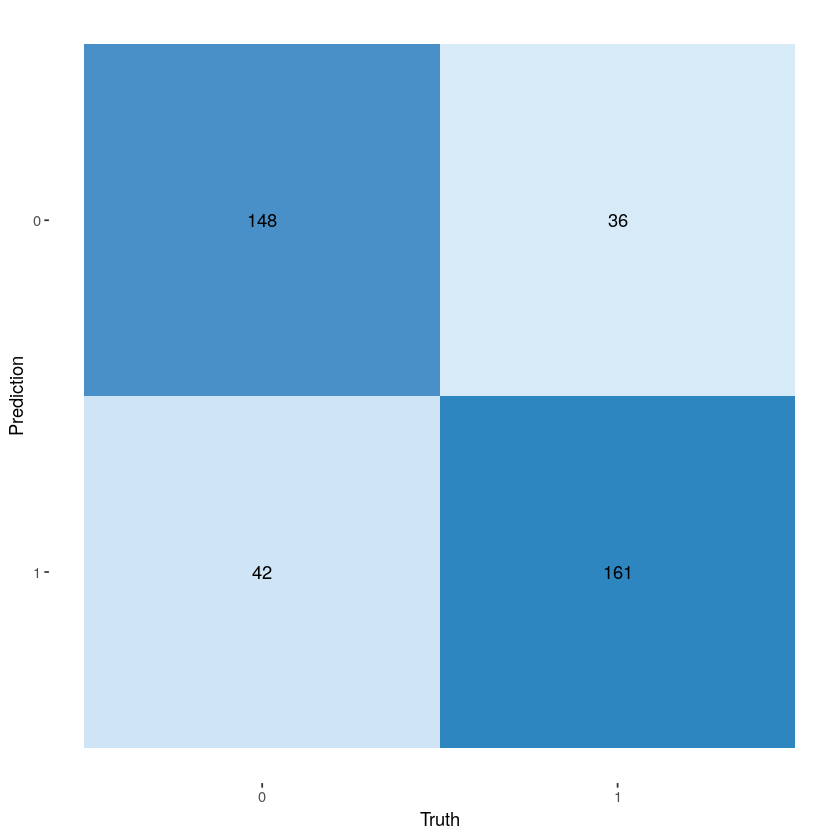

In [13]:
plot_confussion_matrix(modelo, x_test, y_test, 0.5)

### Curva ROC y AUC

La curva ROC (*Receiving Operating Characteristic*) y el área bajo ella, nos permiten validar gráficamente qué tan bien está prediciendo el modelo.  Se trata de una relacion entre la Tasa de Verdaderos Positivos (TPR o Sensitividad) que queremos aumentar y la de Falsos Positivos (FPR o 100 - Especificidad) que queremos disminuir.

Tenga en cuenta que el "Mejor modelo" es el que tiene **Área Bajo la Curva (AUC) = 1** es decir, pasa por la esquina superior izquierda (0,1) y el "Modelo Base" (Aleatorio) es el que tiene **Área Bajo la Curva (AUC) = 0.5** es decir pasa por la diagonal (1,1)

In [14]:
plot_roc_curve <- function(model, x_test, y_test){
  probas <- predict(model, x_test, decision.values = TRUE)
  PRROC_obj <- roc.curve(scores.class0 = probas, 
                         weights.class0=y_test,
                         curve=TRUE)
  plot(PRROC_obj)
}

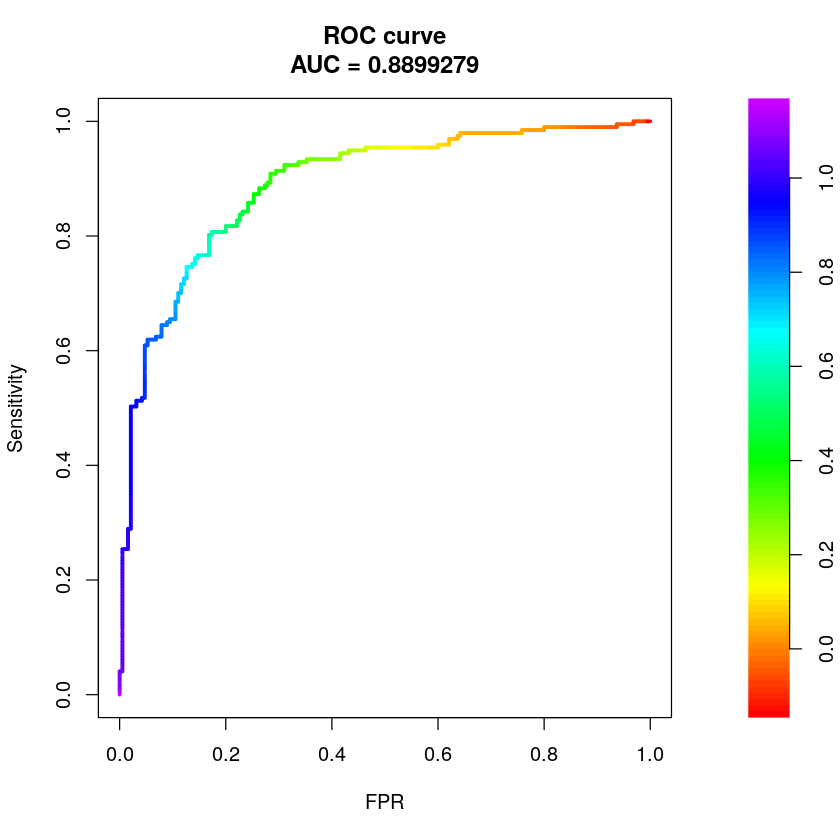

In [15]:
plot_roc_curve(modelo, x_test, y_test)

### Ajuste del Umbral

La curva ROC nos muestra los valores de TPR y FPR para diferentes umbrales del mismo modelo.  Debemos buscar un modelo que tenga el área bajo la curva máxima y entonces, elegir el umbral que aporte el valor máximo de esta curva.  pero cuál es ese umbral óptimo?

Si elegimos un umbral muy alto (Mayor a 0.5 y cercano a 1), el modelo clasificará una menor cantidad de casos positivos (TPR).  Si elegimos un umbral muy bajo (Menor a 0.5 y cercano a 0), el modelo clasificará una mayor cantidad de casos positivos y podría equivocarse (FPR).

In [16]:
plot_precision_recall <- function(model, x_test, y_test){
  probas <- predict(model, x_test, decision.values = TRUE)
  tabla_cm <- data.table(truth = factor(y_test),
                         score = probas)
  pr_data = pr_curve(tabla_cm, truth, score)
  
  pr_data %>%
    arrange(.threshold) %>% 
    ggplot() +
    geom_path(aes(.threshold, precision)) + # connect the points in the order in which they appear in the data to form a curve
    geom_path(aes(.threshold, recall)) +
    coord_equal()
}

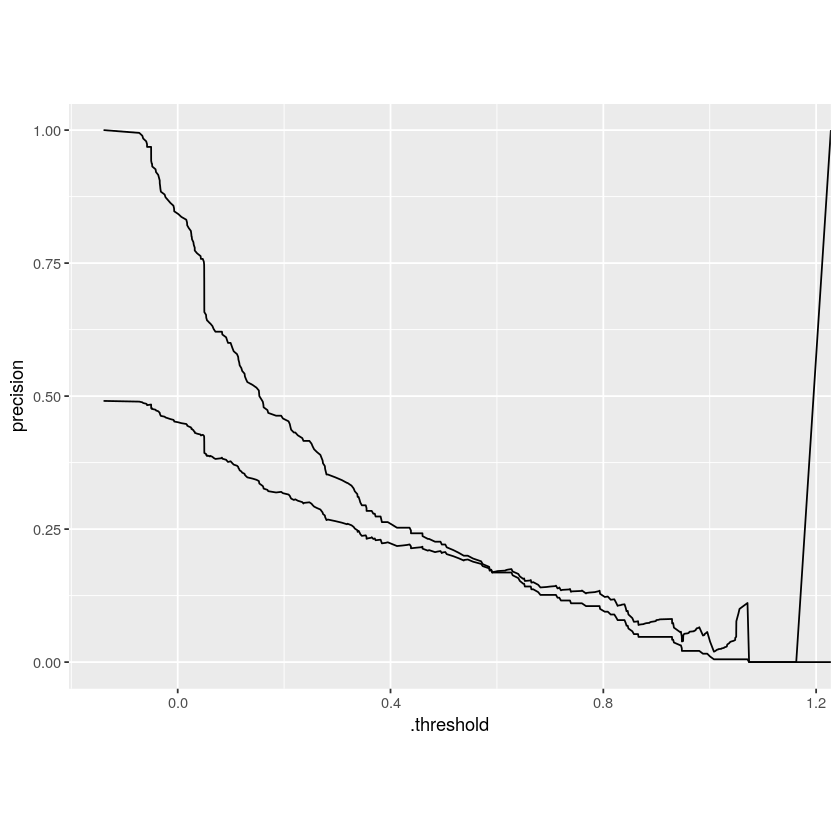

In [17]:
plot_precision_recall(modelo, x_test, y_test)

Es buena práctica, tomar como umbral para nuestro modelo, no siempre 0.5, sino el punto en el que las dos líneas se crucen tal que: La **precisión** del modelo aumente, pero no tanto para que el **recall** caiga demasiado.  

Recuerde que, al cambiar el umbral con el que se mide un modelo, se genera un modelo completamente diferente al que se le deben volver a medir las métricas de validación, por suerte, creamos una función para ello:

          Truth
Prediction   0   1
         0 125  14
         1  65 183
# A tibble: 1 x 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.796
# A tibble: 1 x 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.899
# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.658
# A tibble: 1 x 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 spec    binary         0.929


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



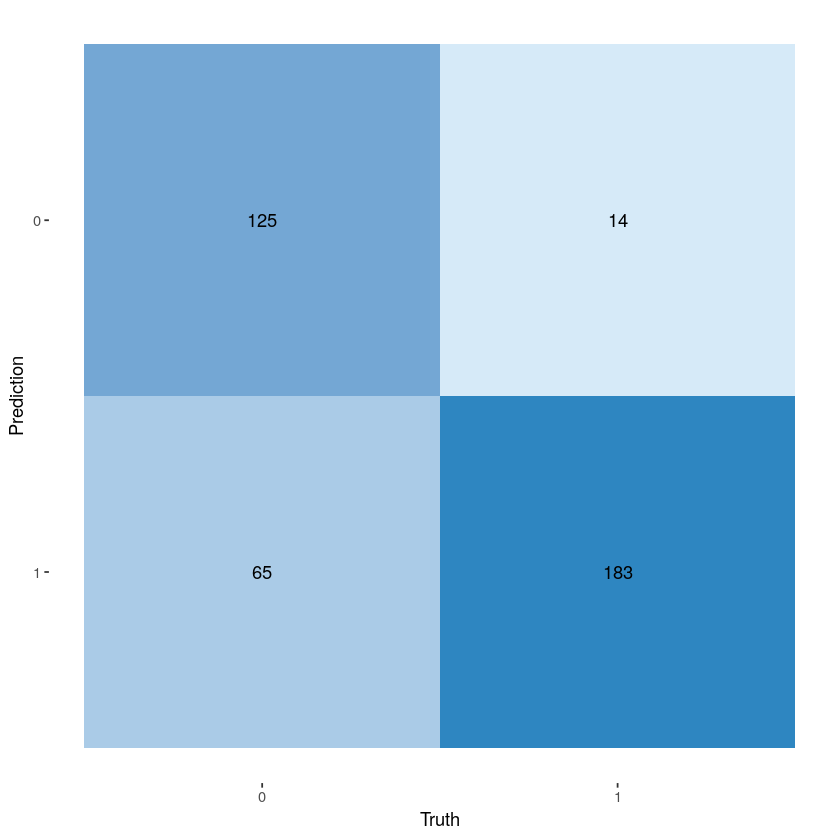

In [18]:
plot_confussion_matrix(modelo, x_test, y_test, 0.3)

**Taller:**  

- Valide las diferentes métricas y gráficas para los modelos que creamos la clase pasada (Se recomienda hacerlo en nuevas celdas, reutilizando las funciones ya creadas, para poder comparar los diferentes modelos)
- Juegue un poco con el umbral del modelo, recuerde que las graficas de las curvas de validación son una recomendación, pero un científico de datos puede moverse con flexibilidad en un rango cercano a ese valor.
- Si queda algo de tiempo, intente eliminar columnas que, según nuestro analisis de los últimos días generan ruido en el modelo o cambiar algunos hiperparámetros
- Finalmente, cuál es el mejor modelo que encontró?